In [ ]:
"""
Implementation of Yolo Loss Function from the original yolo paper
"""

import torch
import torch.nn as nn
from utils import intersection_over_union

## loss 개요


### YoloLoss
* loss fuction을 클래스로 정의함
* grid의 크기를 S, gired cell별 예측 bounding box의 수를 B, 예측하는 calss의 수 C를 생성자로 받는다
* lambda_noobj와 lambda_coord는 가중치 파라미터
* S, B, C, lambda_noobj, lambda_coord의 크기는 논문에 나와있음

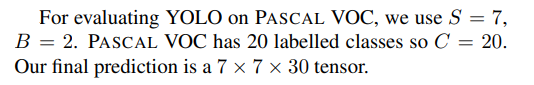

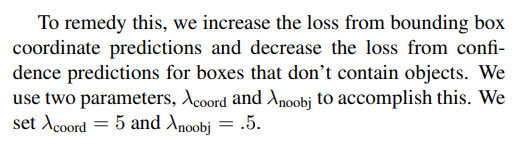



In [ ]:
class YoloLoss(nn.Module):
    """
    Calculate the loss for yolo (v1) model
    """

    def __init__(self, S=7, B=2, C=20):
        super(YoloLoss, self).__init__()
        self.mse = nn.MSELoss(reduction="sum")

        """
        S is split size of image (in paper 7),
        B is number of boxes (in paper 2),
        C is number of classes (in paper and VOC dataset is 20),
        """
        self.S = S
        self.B = B
        self.C = C

        # These are from Yolo paper, signifying how much we should
        # pay loss for no object (noobj) and the box coordinates (coord)
        self.lambda_noobj = 0.5
        self.lambda_coord = 5

### 1-stage detector

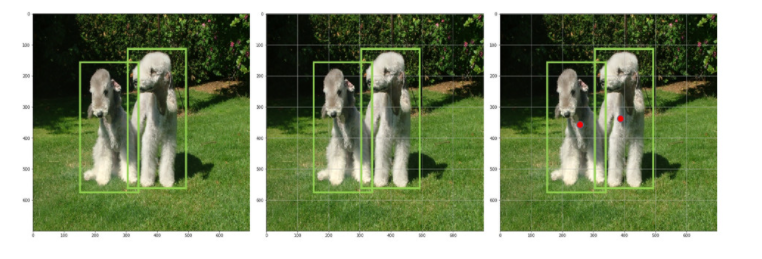

* 전체 이미지를 S * S 크기의 grid로 나누어줌
* 이때 객체의 중심이 특정 gird cell에 위치한다면 객체를 detect하도록 할당된다
* 위의 예시에서는 4행 3열이 왼쪽 개를 예측하도록 할당, 4행 4열이 오른쪽 개를 예측하도록 할당
* 나머지 gride cell은 객체를 예측하는데 참여할 수 없음
* 각각의 grid cell은 B개의 bounding box와 해당 bounding box에 대한 confidence score를 예측.
* confidence score는 bounding box에 객체가 포함되어 있는지 여부와, box가 얼마나 정확하게 예측했는지를 반영하는 수치
* confidence score는 Pr(Object) * IoU(truthpred)로 정의.
* 만약, 객체가 grid cell 내에 존재하지 않는다면 confidence score은 0, 객체가 존재한다면 confidence score은 IoU와 같아짐.

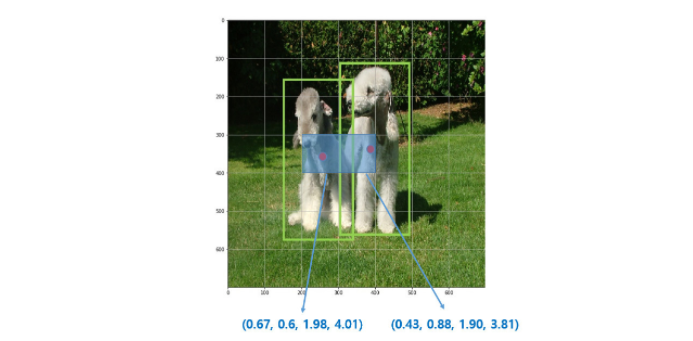

* bounding box는 box의 좌표정보(x, y, w, h)와 confidence score라는 5개의 예측값을 가진다.

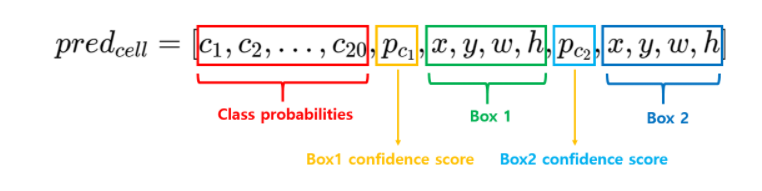

* class probablities는 PASCAL VOC 데이터 세트의 class가 20개이므로 20개임
* 논문에서는 S=7, B=2, C=20 설정, 즉 이미지를 7*7 grid로 나누고 gride cell은 2개의 bounding box와 confidence score, C개의 class probabil를 예측
* 즉, 이미지 별 예측 값 크기는 7 * 7 * (2 * 5 + 20)
* 이를 통해  bounding box의 위치와 크기, 그리고 class에 대한 정보를 동시에 예측하는 것이 가능해짐.

#### foward pass
* 여기서 intersection_over_union는 IoU 즉, 평가지표를 뜻함.

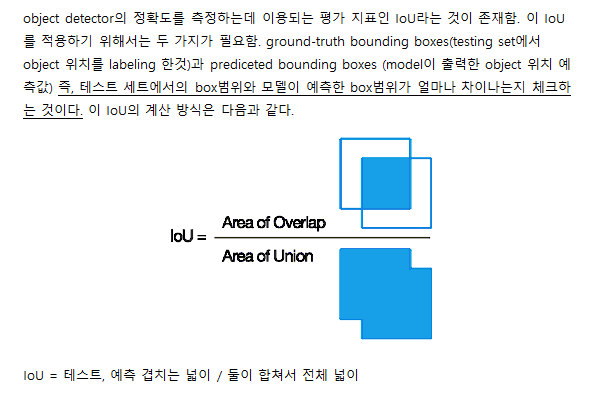

* predictions는 grid cell에 산출한 30개의 정보를 담고있음.

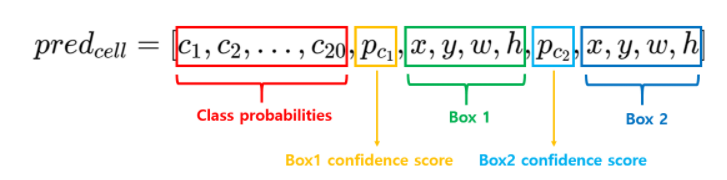

* (predictions[..., 21:25]은 첫 번째 bounding box의 좌표값을, predictions[..., 26:30]는 두 번째 bounding_box의 좌표값을 담고 있음. 이때 target도 함께 사용해서 IoU값을 산출.
* predictions는 최종 산출하는 크기인 7 * 7 * 30 으로 reshape해줌.
* best_box 변 수에는 두 bounding box 중 IoU 큰 값을 저장.

#### Unsqueeze
* 특정한 위치에 1인 차원을 추가한다.

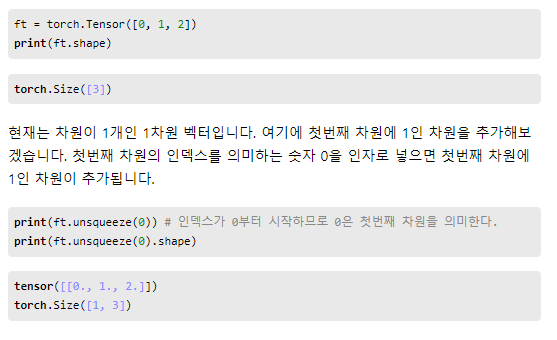

* exists_box는 grid cell에 중심이 존재하는지 여부를 확인, 1이면 존재 0이면 존재하지 않음.



In [ ]:
    def forward(self, predictions, target):
        # predictions are shaped (BATCH_SIZE, S*S(C+B*5) when inputted
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 5)

        # Calculate IoU for the two predicted bounding boxes with target bbox
        iou_b1 = intersection_over_union(predictions[..., 21:25], target[..., 21:25])
        iou_b2 = intersection_over_union(predictions[..., 26:30], target[..., 21:25])
        ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0)

        # Take the box with highest IoU out of the two prediction
        # Note that bestbox will be indices of 0, 1 for which bbox was best
        iou_maxes, bestbox = torch.max(ious, dim=0)
        exists_box = target[..., 20].unsqueeze(3)  # in paper this is Iobj_i


#### Localization loss

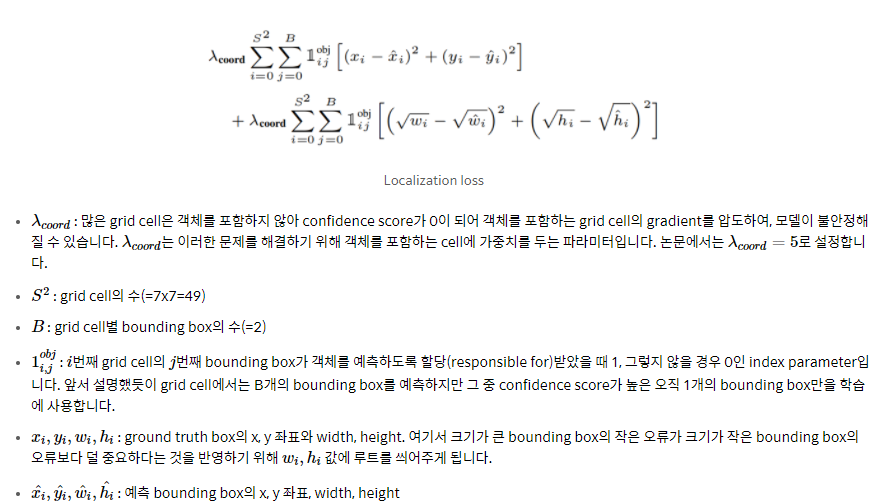

* best_box 변수를 활용하여 실제 bounding box 예측 중 IoU 값이 더 큰 box를 최종 예측으로 사용 
* 그리고 width, height 값에는 루트를 씌워줌
* 이후 bounding box 좌표값에 대하여 mean squared error loss를 계산.

In [ ]:
        # ======================== #
        #   FOR BOX COORDINATES    #
        # ======================== #
        # Set boxes with no object in them to 0. We only take out one of the two 
        # predictions, which is the one with highest Iou calculated previously.
        box_predictions = exists_box * (
            (
                bestbox * predictions[..., 26:30]
                + (1 - bestbox) * predictions[..., 21:25]
            )
        )

        box_targets = exists_box * target[..., 21:25]

        # Take sqrt of width, height of boxes to ensure that
        box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4]) * torch.sqrt(
            torch.abs(box_predictions[..., 2:4] + 1e-6)
        )
        box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])

        box_loss = self.mse(
            torch.flatten(box_predictions, end_dim=-2),
            torch.flatten(box_targets, end_dim=-2),
        )

#### Confidence loss

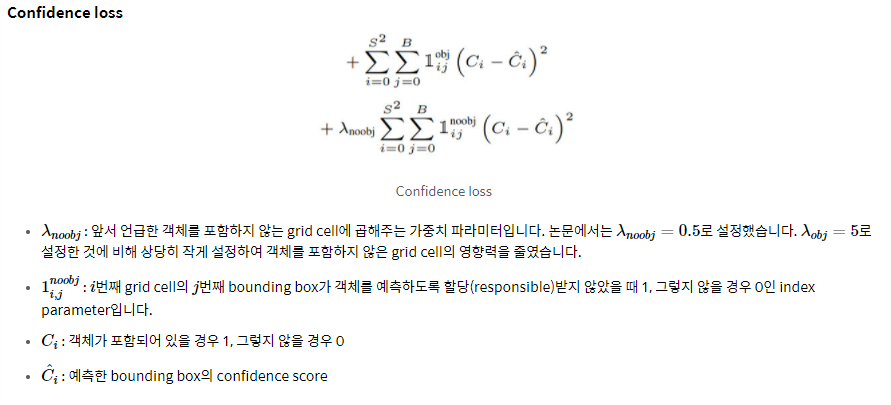

* Object가 존재할 경우/ 존재하지 않을 경우로 분할
* 존재할 경우의 loss부터 구함
* predictions[..., 25:26]은 첫 번째 box의 confidence score를, predictions[..., 20:21]은 두 번째 box의 confidence score를 의미 함
* exists_box 변수를 통해 grid cell에 할당된 ground truth box의 중심이 있는 경우에만 loss를 구한다는 것을 확인
* 없을 경우는 이 경우 두 bounding box를 모두 학습에 참여.

In [ ]:
        # ==================== #
        #   FOR OBJECT LOSS    #
        # ==================== #

        # pred_box is the confidence score for the bbox with highest IoU
        pred_box = (
            bestbox * predictions[..., 25:26] + (1 - bestbox) * predictions[..., 20:21]
        )

        object_loss = self.mse(
            torch.flatten(exists_box * pred_box),
            torch.flatten(exists_box * target[..., 20:21]),
        )
        
        # ======================= #
        #   FOR NO OBJECT LOSS    #
        # ======================= #

        #max_no_obj = torch.max(predictions[..., 20:21], predictions[..., 25:26])
        #no_object_loss = self.mse(
        #    torch.flatten((1 - exists_box) * max_no_obj, start_dim=1),
        #    torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1),
        #)

        no_object_loss = self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 20:21], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1),
        )

        no_object_loss += self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 25:26], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1)
        )

#### Class loss

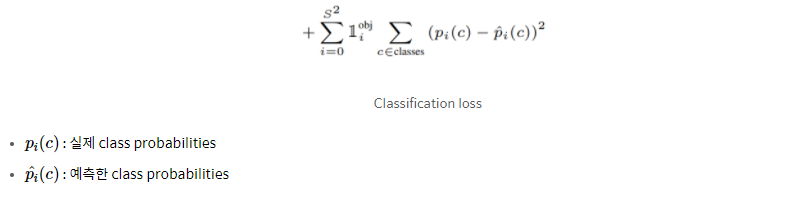

*  predictions[..., :20]에 해당하는 즉 20개의 class의 score를 target과 비교하여 mse loss를 구함
* 이후 가중치 파라미터 lambda_coord를 localization loss에 곱해주고 lambda_noobj를 no_object_loss에 곱해줌
* 이후 모든 loss를 더해서 return 해 준다.

In [ ]:
        # ================== #
        #   FOR CLASS LOSS   #
        # ================== #

        class_loss = self.mse(
            torch.flatten(exists_box * predictions[..., :20], end_dim=-2,),
            torch.flatten(exists_box * target[..., :20], end_dim=-2,),
        )

        loss = (
            self.lambda_coord * box_loss  # first two rows in paper
            + object_loss  # third row in paper
            + self.lambda_noobj * no_object_loss  # forth row
            + class_loss  # fifth row
        )

        return loss